### $\\var epsilon$-Greedy Policy:

$\\begin{array}{l}
\\pi(a|s) =
\\left\\{
\\begin{array}{ll}
1 - \\varepsilon + \\varepsilon / m,& \\text{ если } a \\in \\mathrm{argmax}_{a' \\in \\mathcal{A}}\\, Q(s,a'),\\\\
\\varepsilon / m,& \\text{ иначе }
\\end{array}
\\right.
\\end{array}
$$

In [1]:
import numpy as np

In [19]:
def get_eps_greedy_action(q_values, eps, action_n):
    argmax_action = np.argmax(q_values)
    probs = eps * np.ones(action_n) / action_n
    probs[argmax_action] += 1 - eps
    action = np.random.choice(np.arange(action_n), p = probs)
    return action

### Monte-Carlo Algorithm
Пусть $Q(s,a) = 0$, $N(s,a) = 0$ и $\varepsilon = 1$
    
Для каждого эпизода $k \in \overline{1,K}$ делаем:
    
1. Согласно $\pi = \varepsilon\text{-greedy}(Q)$ получаем траекторию $\tau = (S_0,A_0,\ldots,S_T)$ и награды $(R_0,\ldots,R_{T-1})$. По ним определяем $(G_0,\ldots,G_{T-1}):$ 

$G_t = \sum\limits_{k=t}^{T-1} \gamma^{k-t} R_k,\quad G_{T-1} = R_{T-1},\quad G_{T-2} = R_{T-2} + \gamma R_{T-1},\quad G_i = R_i + \gamma G_{i+1},\quad G_{T} = Q(S_T,\pi_{greedy}(S_T)).$
    
    
    
2. Для каждого $t \in \overline{0,T-1}$ обновляем $Q$ и $N$:
    
$Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \frac{1}{N(S_t,A_t) + 1}\big(G_t - Q(S_t,A_t)\big) $

$N(S_t,A_t) \leftarrow N(S_t,A_t) + 1$

Уменьшаем $\varepsilon$

In [23]:
def monte_carlo(env, episode_n, t_max = 500, gamma = .99):
    
    state_n = env.observation_space.n
    action_n = env.action_space.n
    
    Q = np.zeros((state_n, action_n))
    N = np.zeros((state_n, action_n))
    eps = 1
    
    total_rewards = [] # для контроля обучения
    for i in range(episode_n):
        states, actions, rewards = [], [], []
        
        state = env.reset()
        for t in range(t_max):
            states.append(state)
            
            action = get_eps_greedy_action(Q[state], eps, action_n)
            state, reward, done, _ = env.step(action)
            actions.append(action)
            rewards.append(reward)
            
            if done:
                break
        total_rewards.append(sum(rewards))
        
        G = np.zeros(len(rewards))
        G[-1] = rewards[-1]
        
        for t in range(len(rewards)-2, -1, -1):
            G[t] = G[t+1] * gamma + rewards[t]
            
        for t in range(len(rewards)):
            Q[states[t]][actions[t]] += (G[t] - Q[states[t]][actions[t]]) / (N[states[t]][actions[t]] + 1)
            N[states[t]][actions[t]] += 1 # сколько раз мы побывали в состоянии
            
        eps -= 1 / episode_n
    return total_rewards

In [24]:
import gym
import matplotlib.pyplot as plt

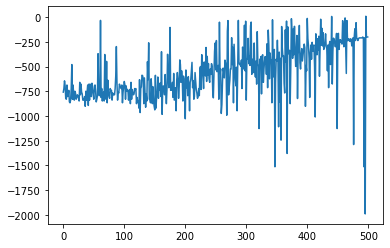

In [26]:
env = gym.make('Taxi-v3')
total_rewards = monte_carlo(env, episode_n = 500, t_max = 500, gamma = .99)
plt.plot(total_rewards)

# sarsa

In [31]:
def sarsa(env, k_max, alpha, t_max, gamma):
    states_n = env.observation_space.n
    actions_n = env.action_space.n
    
    Q = np.zeros((states_n, actions_n))
    total_rewards = []
    eps = 1
    
    #state = env.reset()
    for episode in range(k_max):
        total_reward = 0
        
        state = env.reset()
        action = get_eps_greedy_action(Q[state], eps, actions_n)
        
        for t in range(t_max):
            next_state, reward, done, _ = env.step(action)
            next_action = get_eps_greedy_action(Q[next_state], eps, actions_n)
            
            total_reward += reward
            
            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])
            
            action = next_action
            state = next_state
            
            if done:
                break
        total_rewards.append(total_reward)    
        eps -= 1 / k_max
    return total_rewards

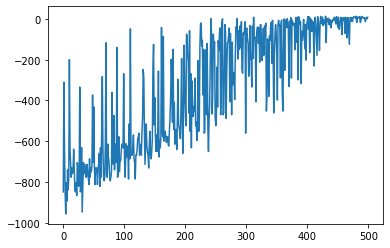

In [32]:
env = gym.make('Taxi-v3')
total_rewards = sarsa(env, k_max = 500, alpha = .5, t_max = 500, gamma = .99)
plt.plot(total_rewards)

# Q-LEARNING

In [37]:
def q_learning(env, k_max, t_max, alpha, gamma):
    
    states_n = env.observation_space.n
    actions_n = env.action_space.n
    
    Q = np.zeros((states_n, actions_n))
    eps = 1
    total_rewards = []
    
    for episode in range(k_max):
        total_reward = 0
        
        state = env.reset()
        action = get_eps_greedy_action(Q[state], eps, actions_n)
        
        for t in range(t_max):
            next_state, reward, done, _ = env.step(action)
            next_action = get_eps_greedy_action(Q[next_state], eps, actions_n)
            
            total_reward += reward
            
            Q[state][action] += alpha * (reward + gamma * max(Q[next_state]) - Q[state][action])
            
            action = next_action
            state = next_state
            
            if done:
                break
            
        total_rewards.append(total_reward)
        eps -= 1 / k_max
    return total_rewards

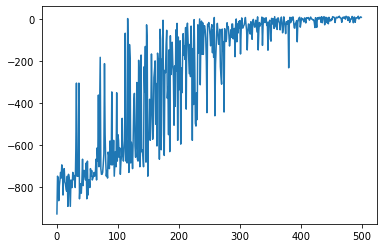

In [38]:
total_rewards = q_learning(env, k_max = 500, alpha = .5, t_max = 500, gamma = .99)
plt.plot(total_rewards)